
# **Programming Assignment 1 - Semantic Segmentation**

#### **Professor**: Dário Oliveira  
#### **Monitor**: Lívia Meinhardt

Neste trabalho prático, vocês irão investigar o desempenho de modelos de segmentação semântica, utilizando redes U-Net e DeepLabV3. A proposta vai além de treinar modelos: vocês deverão analisar onde eles funcionam bem (ou não), interpretar os erros e justificar suas decisões com base nos conceitos vistos em aula.


### **Instruções:**

1. **Escolha do Ambiente de Execução**:  
   Utilize Google Colab ou Kaggle Notebook. Recomendamos iniciar seu notebook no Kaggle diretamente da página do dataset [CamVid](https://www.kaggle.com/datasets/carlolepelaars/camvid).

3. **Criação de um Dataset Customizado**:  
   As máscaras vêm em formato RGB. Use o CSV fornecido para converter as cores em labels (classe por pixel). Crie seu próprio Dataset em PyTorch.

4. **Construção da Arquitetura U-Net**:  
   Implemente uma U-Net (ou ResUNet), com a possibilidade de variar sua profundidade (número de blocos codificadores/decodificadores). Explore como isso impacta o desempenho e a quantidade de parâmetros.

   ![Estrutura U-Net](https://camo.githubusercontent.com/6b548ee09b97874014d72903c891360beb0989e74b4585249436421558faa89d/68747470733a2f2f692e696d6775722e636f6d2f6a6544567071462e706e67)

5. **Função de Treinamento**:  
   Crie uma função de treinamento e registre métricas (loss, acurácia) em cada época. A cada 5 ou 10 épocas, visualize uma predição (imagem original, máscara verdadeira e predita).

6. **Experimentação**:
    Além da profundidade da rede e como ela afeta desempenho e quantidade de parâmetros, explore pelo menos dois otimizadores e funções de perda adequadas para segmentação semântica. Fundamente as escolhas e explique os resultados de acordo com a teoria vista em aula.

8. **Avaliação**:
   Implemente as métricas por classe: Precisão e IoU. Além da média geral, use para identificar as classes com pior desempenho e caracterizar seu melhor modelo.

9. **Explicabilidade com Mapas de Erro**:
   Escolha imagens com desempenho ruim (menor IoU ou precisão) e gere mapas de erro. Analise visualmente onde o modelo erra (bordas, classes confundidas, objetos pequenos, etc.). Relacione os erros às métricas. 

10. **Data Augmentation**:  
     Implemente alguma forma de data augmentation. Avalie se houve ganho em desempenho. Justifique.

11. **Fine-Tuning do DeepLabV3**:
   Realize o fine-tuning do modelo [DeepLabV3](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.segmentation.deeplabv3_resnet50.html#torchvision.models.segmentation.deeplabv3_resnet50) pré-treinado ajustando `classifier` e `aux_classifier` para o número de classes do seu dataset. Congele o backbone conforme necessário e treine o modelo. Compare seu desempenho com a melhor U-Net em termos de métricas, número de parâmetros e qualidade visual das predições.

12. **Apresentação Final**:  
    Ao final, prepare uma apresentação resumindo os passos seguidos, resultados obtidos, gráficos de perdas e acurácia, e discussões sobre o desempenho do modelo. Lembre de fundamentar a discussão com os aspectos teoricos vistos em sala de aula.


### **Pontos Importantes:**

- Escolher adequadamente o tamanho do BATCH, Loss Function e Otimizador e saber o motivo de cada escolha;
- Monitore o uso das GPUs, o kaggle te informa quantidade de tempo disponível, mas o colab não;
- Observe as classes com mais erros por parte do modelo;
- Adicione gráficos de perda e acurácia na sua apresentação;
- Coloque imagens das predições do modelo;
- Use **Pytorch !!!**.

Note que as instruções acima são os requisitos da entrega, mas não precisam ser feitas exatamente nesta ordem. Você pode implementar o lógica de validação do modelo, testar uma versão inicial e modificar conforme os resultados obtidos. Lembre-se de fundamentas suas escolhas e fluxo de trabalho na apresentação. 

In [ ]:
import numpy as np  
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import os 
import time 

import torch
import torchvision
from torch import nn
from torchvision import transforms as  T
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torchvision")

In [2]:
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
import torch, gc
gc.collect()
torch.cuda.empty_cache()

env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


In [3]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


### Convertendo RGB para rótulos

torch.Size([720, 960])
tensor([[21., 21., 21.,  ..., 26., 26., 26.],
        [21., 21., 21.,  ..., 26., 26., 26.],
        [21., 21., 21.,  ..., 26., 26., 26.],
        ...,
        [19., 19., 19.,  ..., 30., 30., 30.],
        [19., 19., 19.,  ..., 30., 30., 30.],
        [19., 19., 19.,  ..., 30., 30., 30.]])


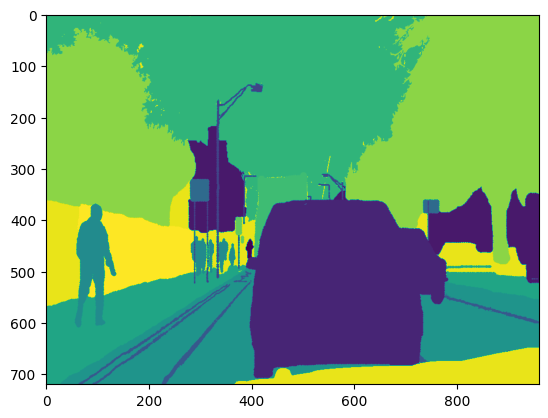

In [4]:
colors  = pd.read_csv('/kaggle/input/camvid/CamVid/class_dict.csv').values[:,1:,] 
colors = torch.from_numpy(colors.astype(int))
n_classes = len(colors)

def mask2label(img):

    img = img.permute(1,2,0)  #read_img muda a ordem dos channels
    w, h, _ = img.shape
    labels = torch.zeros(w, h)

    for i, color in enumerate(colors):
        match = torch.all(torch.abs((img - color)) == 0, axis = -1)
        labels[match] = i
    return labels

img_path = "/kaggle/input/camvid/CamVid/train_labels/0001TP_009210_L.png" #exemplos
img = read_image(img_path)
rotulos = mask2label(img)
print(rotulos.shape)
plt.imshow(rotulos)
print(rotulos)

### Criando o Dataset

In [ ]:
from torchvision.io import read_image

class CamVid(Dataset):
    def __init__(self, root, split):
    
        self.img_folder = os.path.join(root, split)
        self.mask_folder = os.path.join(root, f"{split}_labels")

        self.img_files = os.listdir(self.img_folder)
        self.mask_files = os.listdir(self.mask_folder)

        self.transform = T.Resize(
                (736 // 2, 960 // 2),
                antialias=True,
                interpolation=Image.NEAREST,
            )

    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):

        img = os.path.join(self.img_folder, self.img_files[idx])
        mask = os.path.join(self.mask_folder, self.mask_files[idx])

        img = self.transform(read_image(img).float() / 255.0)
        mask = self.transform(read_image(mask))
        
        mask = mask2label(mask) 

        return img, mask.long()
    
root = "/kaggle/input/camvid/CamVid"
train = CamVid(root=root, split="train")
val = CamVid(root=root, split="val")
test = CamVid(root=root, split="test")
print(len(train), len(val), len(test))

#aumentar o train set com val 
# train+=val

369 100 232


### Implementação da U-NET
ou, alternativamente, a ResUNet

In [ ]:
class UNetConvBlock(nn.Module):  #para implementar a ResUNet, comece alterando esse bloco 
    """
    Duas convoluções 3x3 seguidas, cada uma seguida de uma ativação ReLU
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    """
    Arquitetura da UNet parametrizada pela profundidade e tamanho dos filtros
    """
    def __init__(self, input_channels, num_classes, depth=5, filters=64):
        super().__init__()

        self.depth = depth
        self.pool = nn.MaxPool2d(2)

        #Encoder
        self.encoders = nn.ModuleList() #armazenar um submodulo numa lista 
        for d in range(depth):
            out_ch = filters * 2**d #64; 128; 256...
            conv = UNetConvBlock(input_channels, out_ch)
            self.encoders.append(conv) #nao passamos o maxpool ainda
            input_channels = out_ch #salva próximo input

        #botteneck
        self.bottleneck = UNetConvBlock(filters * 2**(depth-1), filters * 2**depth) #ex: 512 -> 1024

        #decoder
        self.decoder_conv = nn.ModuleList() #armazena as convolucoes 
        self.decoder_upconv = nn.ModuleList() #armazena a camada de upsampling
        for d in reversed(range(depth)):
            out_ch = filters * 2**d #input = out_ch*2 
            self.decoder_conv.append(UNetConvBlock(out_ch * 2, out_ch))  #ex: 1024 -> 512
            self.decoder_upconv.append(nn.ConvTranspose2d(out_ch * 2, out_ch, kernel_size=2, stride=2))

        self.final_conv = nn.Conv2d(filters, num_classes, kernel_size=1) #conv 1x1 final


    def forward(self, x):

        skips = []
        for cur_conv in self.encoders:
            x = cur_conv(x) #aplica convolucao 
            skips.append(x) #salva ultima saida
            x = self.pool(x)  #aplica max pooling

        x = self.bottleneck(x)

        for cur_dec_depth in range(self.depth):
            x = self.decoder_upconv[cur_dec_depth](x) #aplica upsampling
            x = torch.cat([x, list(reversed(skips))[cur_dec_depth]], dim=1) #adiciona skip connection
            x = self.decoder_conv[cur_dec_depth](x) # aplica convolucao

        return self.final_conv(x)
        


# Exemplo de uso:
model = UNet(input_channels=3, num_classes=32, depth=4)
print(model)

UNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoders): ModuleList(
    (0): UNetConvBlock(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (1): UNetConvBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (2): UNetConvBlock(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (3): UNetConvBlock(
      (conv): Sequential(
        (0): Conv2d(256, 512, kernel_size

### Métricas

In [7]:
def precision_per_class(pred, mask):

    with torch.no_grad():
        pred_labels = torch.argmax(pred, dim=1)  # (B, H, W)
        precisions = {}

        for cls in range(n_classes):
            tp = ((pred_labels == cls) & (mask == cls)).sum().float()
            fp = ((pred_labels == cls) & (mask != cls)).sum().float()

            if (tp + fp) == 0:
                precisions[cls] = 0  # nenhuma predição para essa classe
            else:
                precisions[cls] = (tp / (tp + fp)).item()

        return precisions


def iou_per_class(pred, mask):
    with torch.no_grad():
        pred_labels = torch.argmax(pred, dim=1)  # (B, H, W)
        ious = {}

        for cls in range(n_classes):
            pred_inds = (pred_labels == cls)
            target_inds = (mask == cls)

            intersection = (pred_inds & target_inds).sum().float()
            union = (pred_inds | target_inds).sum().float()

            if union == 0:
                ious[cls] = 0 
            else:
                ious[cls] = (intersection / union).item()

        return ious

def pixel_accuracy (pred, mask):
    with torch.no_grad():
        out = torch.argmax(pred, dim = 1)
        correct = torch.eq(out, mask)
        accuracy = torch.sum(correct ) / torch.numel(correct)
    return accuracy.item()

### Função de Treinamento e Experimentação


- Podemos experimentar com (por exemplo):
1. profundidade da rede
2. otimizador 
3. loss function 
4. usar data augmentation

- Vamos usar duas métricas para comparar:
1. IoU (por classe e média)
2. Precision (por classe e média)
3. Acurácia (global)

In [8]:
#parâmetros treino
epochs = 5
batch_size = 8
depth = 2

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(train, batch_size=batch_size, shuffle=False)

model = UNet(input_channels=3, num_classes=32, depth=depth).to(device)
otimizador = torch.optim.AdamW(model.parameters(), lr=0.001)
criterio = nn.CrossEntropyLoss()

In [11]:
history = {'time_taken':[],'train_loss': [],'val_loss': [],'train_acc': [], 'val_acc': []}
def mean(a): return sum(a)/len(a)
    
for epoch in range(epochs):

    start_t, train_loss, val_loss,train_acc, val_acc = time.time(), [], [],[],[]

    #treino
    model.train()
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterio(outputs, masks)
        otimizador.zero_grad()
        loss.backward()
        otimizador.step()
        
        train_loss.append(loss.item())
        train_acc.append(pixel_accuracy(outputs, masks))
        break
    break
    #mteste
    model.eval()
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterio(outputs, masks)
            val_loss.append(loss.item())
            val_acc.append(pixel_accuracy(outputs, masks))

    t = time.time() - start_t
    print(f'Epoch: {epoch + 1}/{epochs}, '
      f'Train Loss: {mean(train_loss):.3f}, '
      f'Val Loss: {mean(val_loss):.3f}, '
      f'Train Acc: {mean(train_acc):.3f}, '
      f'Val Acc: {mean(val_acc):.3f}, '
      f'Time Taken: {(t / 60):.3f} min')
    
    
    history['train_loss'].append(mean(train_loss))
    history['val_loss'].append(mean(val_loss))
    history['train_acc'].append(mean(train_acc))
    history['val_acc'].append(mean(val_acc))
    history['time_taken'].append(t)

## Métricas

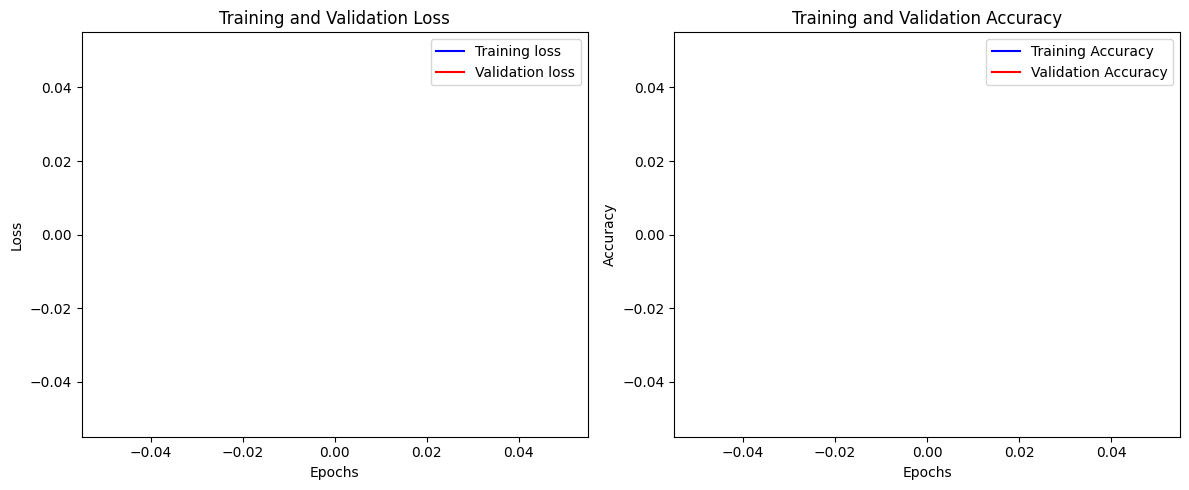

In [12]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot da perda (loss)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b', label='Training loss')
    plt.plot(epochs, history['val_loss'], 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot da acurácia (accuracy)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Exemplo de uso
plot_history(history)


### Mapas de Confiança

In [13]:
def error_map(pred, mask):
    with torch.no_grad():
        pred_labels = torch.argmax(pred, dim=1)  # (B, H, W)
        errors = (pred_labels != mask).int()     # 1 = erro, 0 = acerto
    return errors

In [ ]:
# Exemplo com 1 imagem
errors = error_map(outputs, masks)[0].cpu()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("Output")
plt.imshow(outputs[0][0].cpu()) 

plt.subplot(1,3,2)
plt.title("Label")
plt.imshow(masks[0].cpu(), cmap="tab20")

plt.subplot(1,3,3)
plt.title("Mapa de Erros")
plt.imshow(errors, cmap="Reds")  # vermelho = erro
plt.show()


In [ ]:
iou_per_class(outputs, masks)

In [ ]:
precision_per_class(outputs, masks)

## Modelo pre treinado

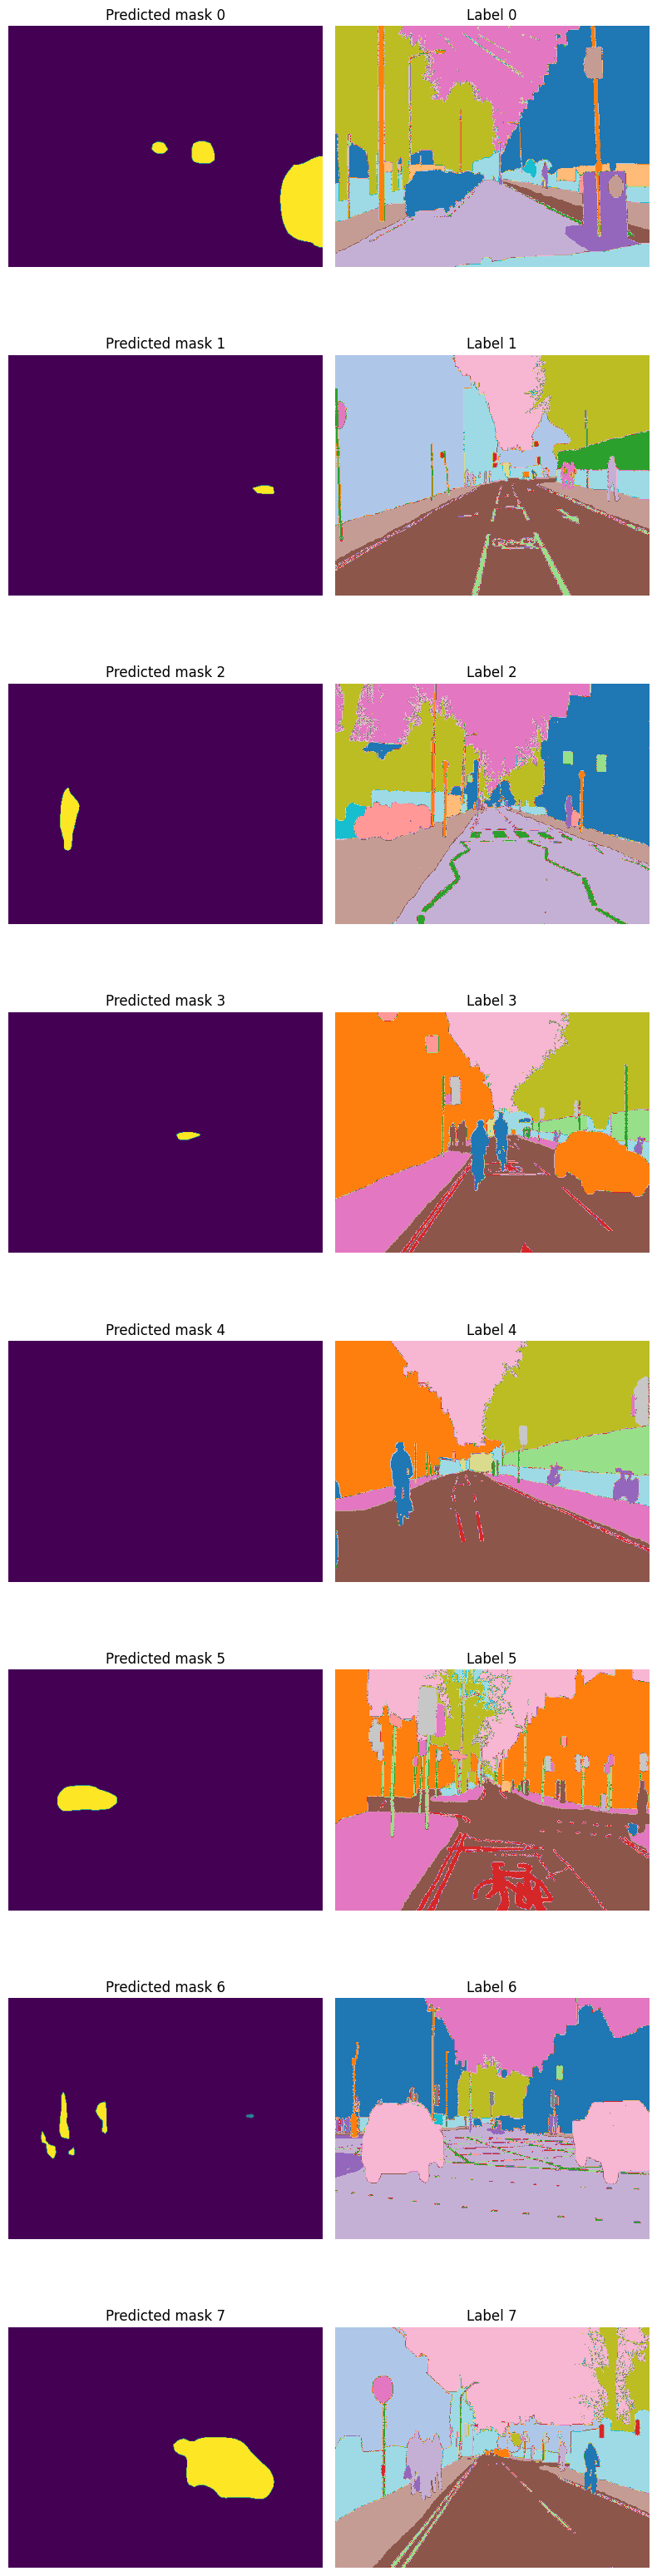

In [72]:
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
model = model.eval().cuda()  # usa GPU se disponível

for images, masks in train_loader:break
    
with torch.no_grad():
    output = model(images.cuda())["out"]  # batch inteiro

pred_mask = output.argmax(1).cpu().numpy()

plt.figure(figsize=(8, 4 * batch_size))  # altura proporcional ao batch_size

for i in range(batch_size):
    # Máscara predita
    plt.subplot(batch_size, 2, 2*i + 1)
    plt.title(f"Predicted mask {i}")
    plt.imshow(pred_mask[i])  # se pred_mask ainda for tensor
    plt.axis("off")
    
    # Máscara real
    plt.subplot(batch_size, 2, 2*i + 2)
    plt.title(f"Label {i}")
    plt.imshow(masks[i].cpu(), cmap="tab20")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [41]:
model.classifier[4] = nn.Conv2d(256, n_classes, kernel_size=(1, 1), stride=(1, 1))

#congelar até o classifier
for p_name, param in model.named_parameters():
    if 'classifier' in p_name:
        break
    param.requires_grad = False

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [61]:
num_epochs = 10
model.to(device)
model.train()
for epoch in range(num_epochs):
    for images, masks in train_loader:
        if len(images) != batch_size: break
        images, masks = images.cuda(), masks.cuda()

        optimizer.zero_grad()
        outputs = model(images)['out']  
        
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

libpng warning: iCCP: known incorrect sRGB profile


Epoch 1/10, Loss: 1.3208


libpng warning: iCCP: known incorrect sRGB profile


Epoch 2/10, Loss: 1.4082


libpng warning: iCCP: known incorrect sRGB profile


Epoch 3/10, Loss: 1.3895


libpng warning: iCCP: known incorrect sRGB profile


Epoch 4/10, Loss: 1.2293


libpng warning: iCCP: known incorrect sRGB profile


Epoch 5/10, Loss: 1.2585


libpng warning: iCCP: known incorrect sRGB profile


Epoch 6/10, Loss: 1.3413


libpng warning: iCCP: known incorrect sRGB profile


Epoch 7/10, Loss: 1.0721


libpng warning: iCCP: known incorrect sRGB profile


Epoch 8/10, Loss: 1.0414


libpng warning: iCCP: known incorrect sRGB profile


Epoch 9/10, Loss: 1.0300


libpng warning: iCCP: known incorrect sRGB profile


Epoch 10/10, Loss: 0.9462


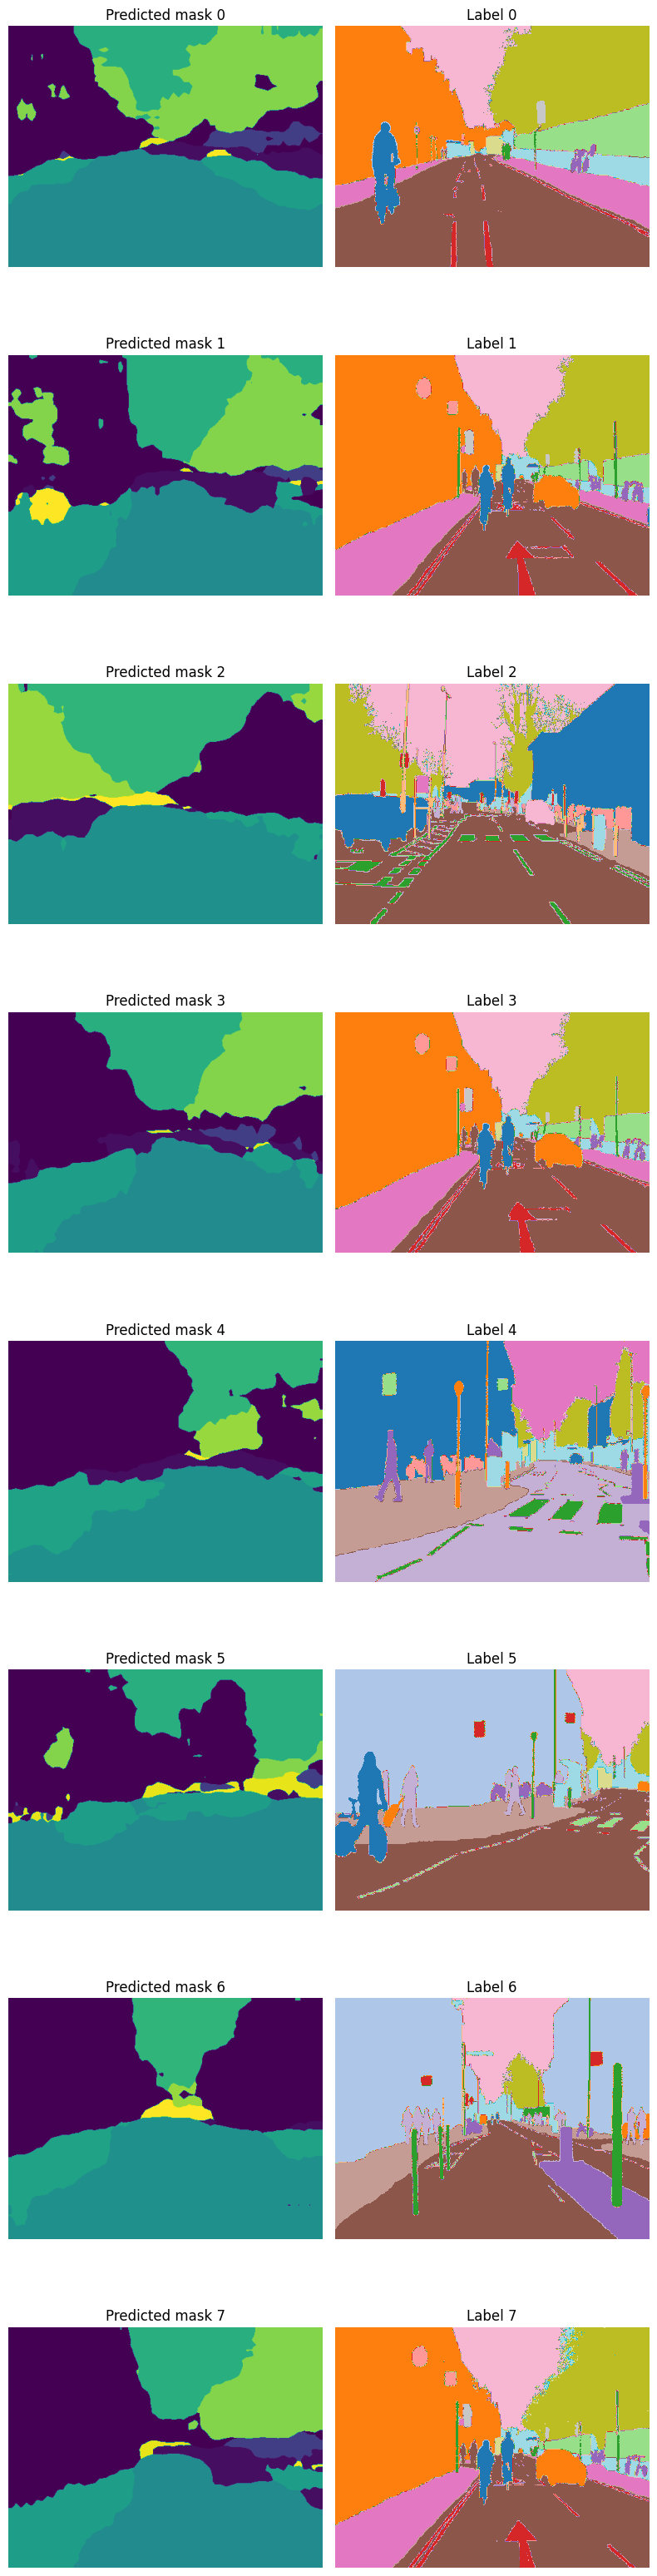

In [66]:
for images, masks in train_loader:break
with torch.no_grad():
    output = model(images.cuda())["out"]  # batch inteiro

pred_mask = output.argmax(1).cpu().numpy()

plt.figure(figsize=(8, 4 * batch_size))  # altura proporcional ao batch_size

for i in range(batch_size):
    # Máscara predita
    plt.subplot(batch_size, 2, 2*i + 1)
    plt.title(f"Predicted mask {i}")
    plt.imshow(pred_mask[i])  # se pred_mask ainda for tensor
    plt.axis("off")
    
    # Máscara real
    plt.subplot(batch_size, 2, 2*i + 2)
    plt.title(f"Label {i}")
    plt.imshow(masks[i].cpu(), cmap="tab20")
    plt.axis("off")

plt.tight_layout()
plt.show()